# House price prediction
## Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data Import

In [58]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


집 가격 예측에 중요한 변수가 무엇일지 고민해보기.
-> 집 값은 부동산 정책이나 흐름에 따라 많이 변하기도 하므로 LASSO도 고려해보기
-> 변수가 너무 많으면 모델의 성능이 안좋을 수도 있음 (지하실 부분 제외.우편번호도 제외)
-> 20,21도 어짜피 재건축 년도 등의 정보 있으므로 제외
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
//6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
// 14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
// 17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
//20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
//21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [59]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
train.head()
#train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [60]:
train.drop(['sqft_living','sqft_basement','zipcode','sqft_living15','sqft_lot15'],axis=1,inplace=True)
test.drop(['sqft_living','sqft_basement','zipcode','sqft_living15','sqft_lot15'],axis=1,inplace=True)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,lat,long
0,0,20141013,221900.0,3,1.00,5650,1.0,0,0,3,7,1180,1955,0,47.5112,-122.257
1,1,20150225,180000.0,2,1.00,10000,1.0,0,0,3,6,770,1933,0,47.7379,-122.233
2,2,20150218,510000.0,3,2.00,8080,1.0,0,0,3,8,1680,1987,0,47.6168,-122.045
3,3,20140627,257500.0,3,2.25,6819,2.0,0,0,3,7,1715,1995,0,47.3097,-122.327
4,4,20150115,291850.0,3,1.50,9711,1.0,0,0,3,7,1060,1963,0,47.4095,-122.315


In [61]:
# 언제부터의 데이터? 14.5.2 ~ 15.5.14 
print(train.date.min())
print(train.date.max())

20140502
20150514


## Visualization

### 연속형
- 아래 그림을 보면 특정 지점에 위도 경도 가격, 평수 등이 몰려 있는 편

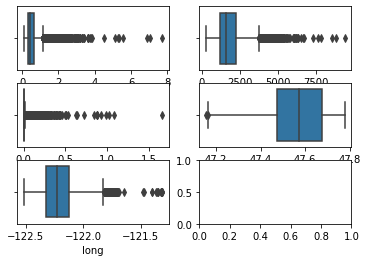

In [62]:
# 연속형 변수 시각화
fig, axes = plt.subplots(3,2)
ax = sns.boxplot(train['price'], ax = axes[0,0])
ax = sns.boxplot(train['sqft_above'], ax = axes[0,1])
ax = sns.boxplot(train['sqft_lot'], ax = axes[1,0])
ax = sns.boxplot(train['lat'], ax = axes[1,1])
ax = sns.boxplot(train['long'], ax = axes[2,0])

아래 그래프를 보면,
- 지하실을 제외한 평방미터가 커질수록 가격도 높아지는 편
- 부지가 커도 가격이 낮을수도 있고, 부지가 작아도 가격이 클수도 있음 => 제외 고려
- 위도 경도도 그냥 제외

Text(0.5, 1.0, 'long')

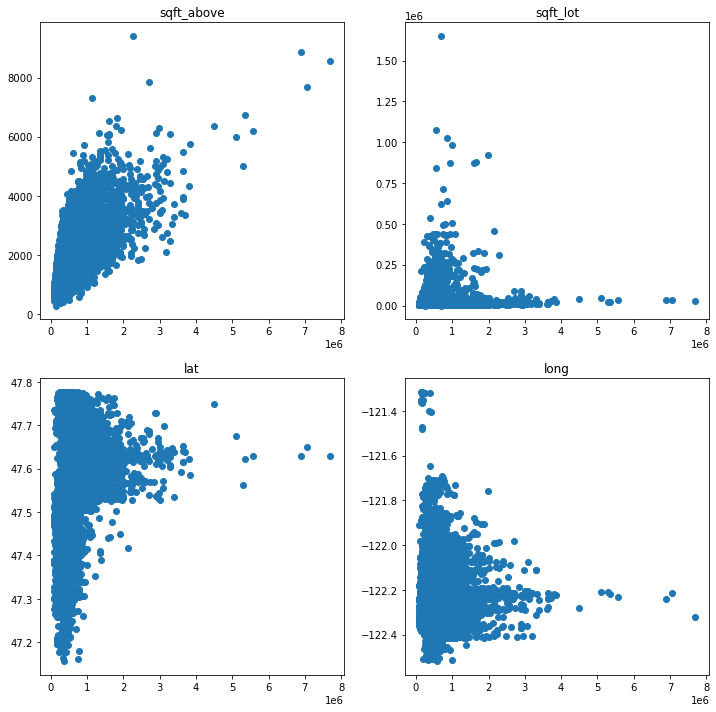

In [7]:

fig, axes = plt.subplots(2,2, figsize = (12,12))

# price와 sqft_above, sqft_lot의 correlation
axes[0,0].plot('price','sqft_above',data=train,linestyle='none', marker='o')
axes[0,0].set_title('sqft_above')
axes[0,1].plot('price','sqft_lot',data=train,linestyle='none', marker='o')
axes[0,1].set_title('sqft_lot')
axes[1,0].plot('price','lat',data=train,linestyle='none', marker='o')
axes[1,0].set_title('lat')
axes[1,1].plot('price','long',data=train,linestyle='none', marker='o')
axes[1,1].set_title('long')

In [63]:
train.drop(['date'],axis=1,inplace=True)
test.drop(['date'],axis=1,inplace=True)
#train.head()

### 범주형
- 아래 그림을 보면, grade 높을수록 가격 높고
- 상태는 3만 넘으면 가격 쳐주는 편
- view도 좋을수록 가격이 좋아지는 것 같음
- waterfront가 더 비쌌음
- floor는 크게 관련이 없어 보임. 너무 낮은 층만 아니면 되는 정도?
- 아마 화장실이 많이면 면적도 커서(확인은 안해봄) 화장실 갯수가 늘어날수록 비싸지는 것 같음.
- 침실 갯수도 화장실 갯수와 일맥상통

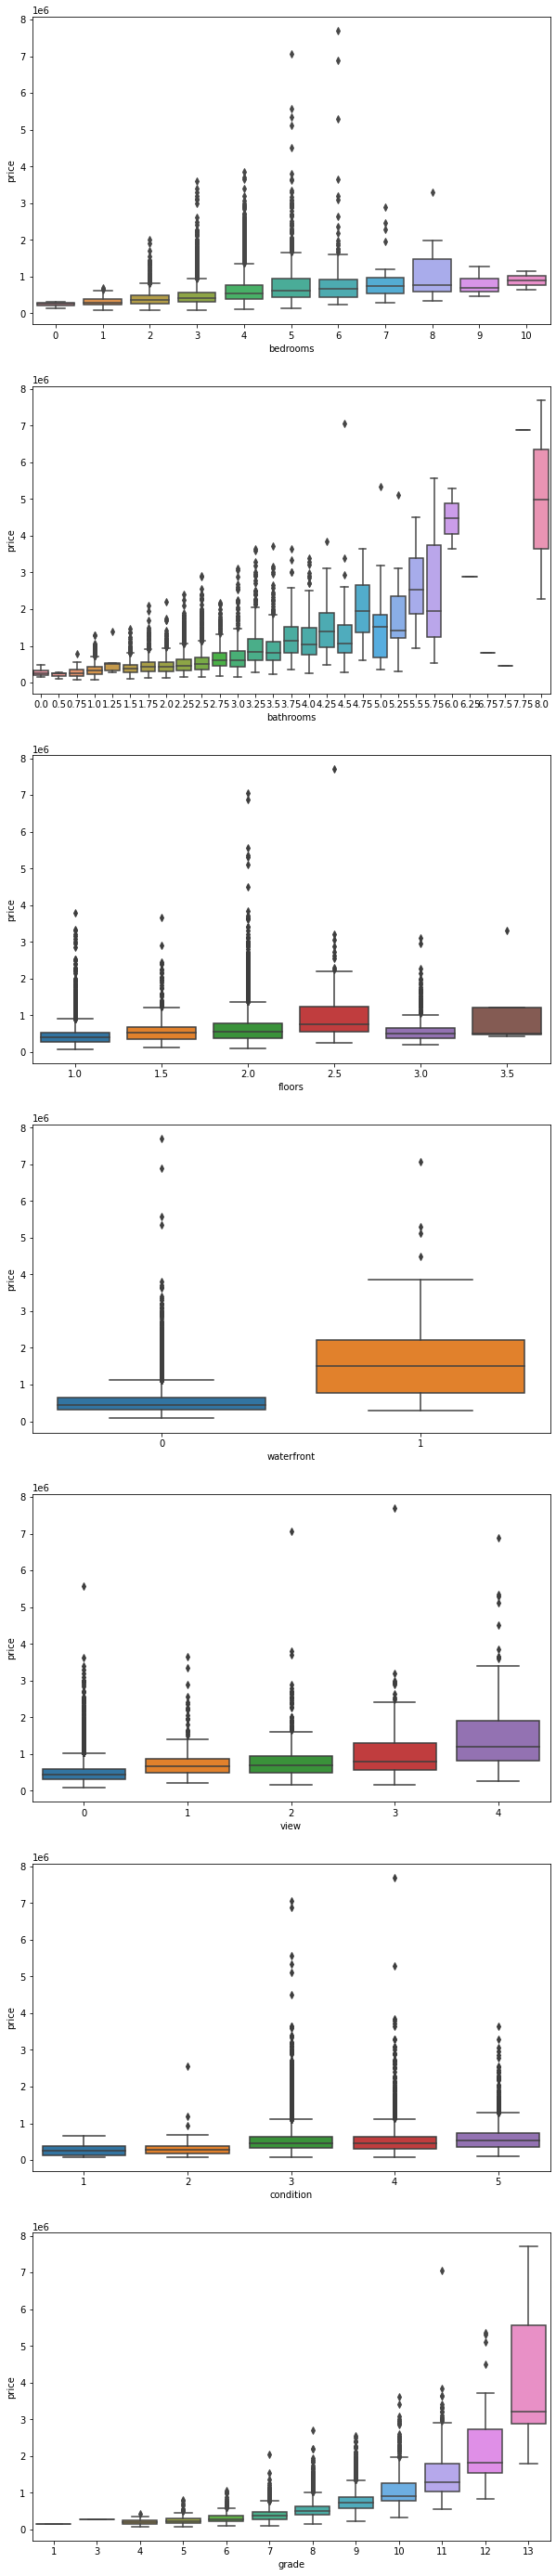

In [64]:
# 범주형 변수 확인
fig, axes = plt.subplots(7,1, figsize = (10,50))

ax = sns.boxplot(x='bedrooms',y='price',data=train, ax = axes[0])
ax = sns.boxplot(x='bathrooms',y='price',data=train, ax = axes[1])
ax = sns.boxplot(x='floors',y='price',data=train, ax = axes[2])
ax = sns.boxplot(x='waterfront',y='price',data=train, ax = axes[3])
ax = sns.boxplot(x='view',y='price',data=train, ax = axes[4])
ax = sns.boxplot(x='condition',y='price',data=train, ax = axes[5])
ax = sns.boxplot(x='grade',y='price',data=train, ax = axes[6])

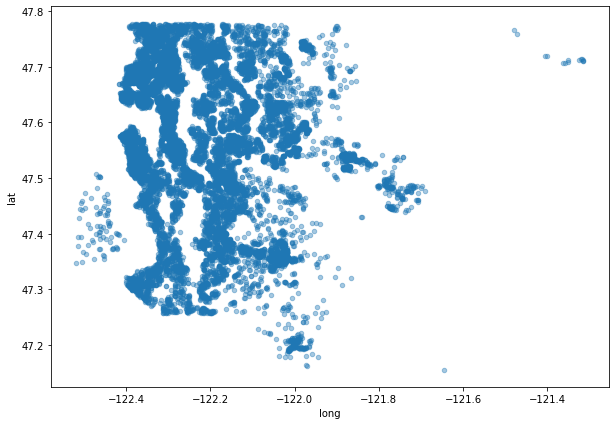

In [10]:
train.plot(kind="scatter", x="long", y="lat", alpha=0.4, figsize=(10,7))

In [11]:
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(data_transformed)
#     Sum_of_squared_distances.append(km.inertia_)

In [12]:
# target
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated',
       'lat', 'long'],
      dtype='object')


In [13]:
del train['id']
del test['id']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated', 'lat',
       'long'],
      dtype='object')


In [14]:
#test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
#test['date'] = pd.to_datetime(test['date'],format='%Y%m%d')

In [15]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

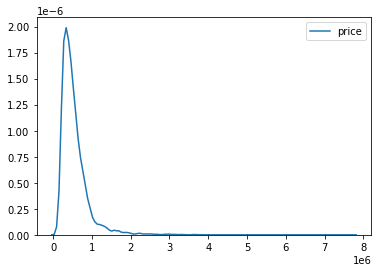

In [16]:
# 분포확인
sns.kdeplot(y)

In [17]:
# 로그 변환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

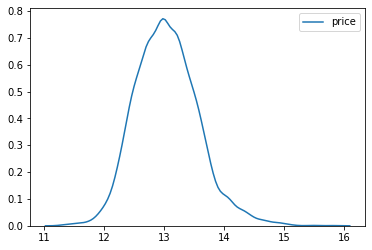

In [18]:
sns.kdeplot(y)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      15035 non-null  int64  
 1   bathrooms     15035 non-null  float64
 2   sqft_lot      15035 non-null  int64  
 3   floors        15035 non-null  float64
 4   waterfront    15035 non-null  int64  
 5   view          15035 non-null  int64  
 6   condition     15035 non-null  int64  
 7   grade         15035 non-null  int64  
 8   sqft_above    15035 non-null  int64  
 9   yr_built      15035 non-null  int64  
 10  yr_renovated  15035 non-null  int64  
 11  lat           15035 non-null  float64
 12  long          15035 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 1.5 MB


In [20]:
# RMSE 계산
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [21]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [54]:
#Constructing an ensemble regressor (simply calculates the mean)
def EnsembleRegressor(regressors,X_Validation):
    EnsemblePred = pd.DataFrame()
    for reg in regressors:
        colname = str(reg)[:4]
        EnsemblePred[colname] = reg.predict(X_Validation)
    EnsemblePred["Ensemble"] = EnsemblePred.apply(lambda x: np.mean(x), axis=1) #Mean scores better than median
    return EnsemblePred

result = EnsembleRegressor(models,test)

In [22]:
# 이름 확인
gboost.__class__.__name__

'GradientBoostingRegressor'

In [23]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
    
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,136718.912940
RandomForestRegressor,129121.861090
XGBRegressor,119908.473518
LGBMRegressor,115879.556533


In [51]:
# Grid Search
param_grid = {
    'n_estimators': [10, 200],
    'max_depth': [1, 10],
    'mean_child_weight': [1e-3, 1e-1]
}
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 150), 
            # 'learning_rate':0.01,
             'min_child_samples': sp_randint(10, 100), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
# fit_params={"early_stopping_rounds":30, 
#             "eval_metric" : 'auc', 
#             "eval_set" : [(test,test['price'])],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': 100,
#             'categorical_feature': 'auto'}

In [37]:
model = LGBMRegressor(random_state=random_state)

In [52]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     grid_model = GridSearchCV(model, param_grid=param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)

    grid_model = RandomizedSearchCV(
        estimator=model, param_distributions=param_test, 
        n_iter=1000,
        scoring='neg_mean_squared_error',
        cv=3,
        refit=True,
        random_state=2020,
        verbose=True)
    
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    param_df = pd.DataFrame(params)
    param_df['score'] = score
    param_df['RMSE'] = np.sqrt(-1 * param_df['score'])
    param_df = param_df.rename(columns={'RMSE': 'RMSLE'})
    param_df = param_df.sort_values(by = ['RMSLE'])
    
    return param_df

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    0.8s finished


,max_depth,mean_child_weight,n_estimators,score,RMSLE
5,10,0.001,200,-0.029036,0.170400
7,10,0.100,200,-0.029036,0.170400
1,1,0.001,200,-0.050476,0.224668
3,1,0.100,200,-0.050476,0.224668
4,10,0.001,10,-0.082919,0.287956
6,10,0.100,10,-0.082919,0.287956
0,1,0.001,10,-0.166998,0.408654
2,1,0.100,10,-0.166998,0.408654


In [27]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   19.8s finished


,colsample_bytree,min_child_samples,min_child_weight,num_leaves,reg_alpha,reg_lambda,subsample,score,RMSLE
35,0.575673,29,0.00100,55,0.1,0.1,0.950495,-0.029539,0.171871
60,0.900134,56,0.00001,33,0.0,10.0,0.977836,-0.030097,0.173486
39,0.666826,62,0.00100,83,1.0,50.0,0.814926,-0.030459,0.174526
72,0.785111,149,10.00000,73,0.0,0.1,0.301330,-0.031664,0.177944
69,0.754228,13,100.00000,24,2.0,0.1,0.512370,-0.031673,0.177969
...,...,...,...,...,...,...,...,...,...
61,0.617641,427,10000.00000,17,10.0,50.0,0.794463,-0.278637,0.527861
6,0.679590,232,10000.00000,20,7.0,50.0,0.629621,-0.278637,0.527861
19,0.950117,263,10000.00000,50,0.1,1.0,0.232762,-0.278637,0.527861
52,0.754213,85,10000.00000,8,1.0,0.1,0.937065,-0.278637,0.527861


In [28]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train,y)
    prediction = model.predict(test)
    # 원래 스케일로 복구
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [53]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.170400')

/home/aiffel0036/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.170400.csv saved!


# 결론
- 미국 데이터인 만큼 한국과는 다르게 미국에서 집값에 중요한 것이 무엇인지 미리 찾아보는 것이 중요할 것 같다.
- 위치가 집값에 매우 중요한 요소기 때문에, 위도 경도를 2차원에 분산한 후 클러스터링 하여 라벨링을 한 뒤 변수로 넣으면 좀 더 정확도가 좋아지지 않을까 싶다.
- random, grid search 둘 다 사용해보았는데 별 차이가 없었다.
- regressor들을 모두 사용한 ensemble 기법을 적용을 하면 더 성능이 좋아질 것 같다.
- 시간이 부족해서 위의 것들을 못한 것이 아쉽지만 실제로 대회를 나갈 때는 활용하면 될 것 같다.